In [ ]:
# This model is incomplete & has problems, never attemp to run, will crash your PC

In [16]:
import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
import datetime

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

print("OK")

2.9.0
OK


In [17]:
#change this line:
work_dir = "/Users/gohyixian/Downloads"

In [18]:
train_dir = work_dir + "/NLP-Depression/Dataset/training_data.csv"
train_all = pd.read_csv(train_dir, index_col=False, encoding="utf-8")
train_all.head()

,text_join,class
0,want go fun scared famely would find bi,1
1,guys heard new restaurant moon,0
2,republican party decide stands right stands se...,0
3,always told nala neighborhood dog old whenever...,0
4,years ago audition second novel tsr 's brand n...,0


In [19]:
from sklearn.model_selection import train_test_split

# train-test split, default: train=0.75, test=0.25
x_train, x_test, y_train, y_test = train_test_split(train_all["text_join"], train_all["class"], random_state=0)

# some data type compatibility formatting
x_train = np.asarray(x_train.to_frame().to_numpy(dtype=np.string_)).astype(np.string_)
x_test = np.asarray(x_test.to_frame().to_numpy(dtype=np.string_)).astype(np.string_)
y_train = np.asarray(y_train.to_frame().to_numpy(dtype=np.string_)).astype(np.string_)
y_test = np.asarray(y_test.to_frame().to_numpy(dtype=np.string_)).astype(np.string_)


# convert y data to labels of [0,1,0]
# one-hot encoding
def createLabels(y):
    counter = 0
    result = np.array([[]])
    # initialize np.array based on first Training Example
    if y[0] == np.string_("0"):
        result = np.array([[1,0,0]])
    elif y[0] == np.string_("1"):
        result = np.array([[0,1,0]])
    elif y[0] == np.string_("2"):
        result = np.array([[0,0,1]])
    
    # skip the first, process the other training examples
    for i in y:
        if counter > 0:
            if i == np.string_("0"):
                result = np.append(result, np.array([[1,0,0]]), axis=0)
            elif i == np.string_("1"):
                result = np.append(result, np.array([[0,1,0]]), axis=0)
            elif i == np.string_("2"):
                result = np.append(result, np.array([[0,0,1]]), axis=0)
        counter+=1
        
    return result


# x_train = x_train.to_frame()
# print(type(x_train))
# print(x_train)

y_train = createLabels(y_train)
y_test = createLabels(y_test)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train)

(65529, 1)
(65529, 3)
(21844, 1)
(21844, 3)
[[0 0 1]
 [0 1 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [1 0 0]]


In [20]:
# review max text data length
len_df = train_all["text_join"].apply(lambda x: len(str(x).split(" ")))
max_len = len_df.max()
print(max_len)

5695


array([[<AxesSubplot:title={'center':'text_join'}>]], dtype=object)

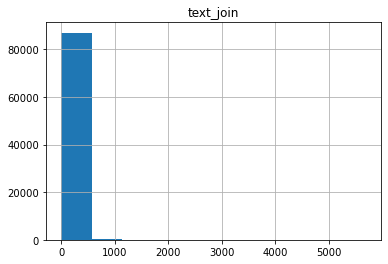

In [21]:
import seaborn as sns

len_df_pd = pd.DataFrame(len_df)
len_df_pd.hist(bins=10)
# we can see that most data has len < 700, thus we will use
# 1000 as the max text len for our BERT model

In [22]:
x_train[0]

array([b'helppart wants end life part wants live last night got lucky tried end failed scared might end'],
      dtype='|S32293')

In [7]:
pretrained_model_name = "bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name,
                                                            num_labels=4)
print("OK")

Metal device set to: Apple M1


2022-06-15 03:41:17.490890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 03:41:17.491383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OK


In [8]:
# sample use of tokenizer : sub-word embedding
tokenizer.tokenize("I am downloading a BERT model")

['I', 'am', 'download', '##ing', 'a', 'B', '##ER', '##T', 'model']

In [9]:
# convert to python list
# train_texts

# train_texts = list(map((lambda x: x.decode("UTF-8")), x_train.tolist()))
train_texts = list(map((lambda x: str(x)), x_train.tolist()))
test_texts = list(map((lambda x: str(x)), x_test.tolist()))


#tokenize training data
train_tokens = tokenizer(train_texts,
                         max_length=700,              # max length of content, faster, save space too
                         truncation=True,             # truncate words > 700
                         padding="max_length",        # pad shorter text to max_length
                         add_special_tokens=True,     # special tokens like [CLS], start-of-line
                         return_token_type_ids=False, # we don't need tokean type id in fine tuning here
                         return_tensors="tf")         # return tensorflow tensor

#tokenize test data
test_tokens = tokenizer(test_texts,
                        max_length=700,              # max length of content, faster, save space too
                        truncation=True,             # truncate words > 700
                        padding="max_length",        # pad shorter text to max_length
                        add_special_tokens=True,     # special tokens like [CLS], start-of-line
                        return_token_type_ids=False, # we don't need tokean type id in fine tuning here
                        return_tensors="tf")         # return tensorflow tensor
print("OK")

OK


In [10]:
train_tokens

{'input_ids': <tf.Tensor: shape=(65529, 700), dtype=int32, numpy=
array([[101, 164, 171, ...,   0,   0,   0],
       [101, 164, 171, ...,   0,   0,   0],
       [101, 164, 171, ...,   0,   0,   0],
       ...,
       [101, 164, 171, ...,   0,   0,   0],
       [101, 164, 171, ...,   0,   0,   0],
       [101, 164, 171, ...,   0,   0,   0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(65529, 700), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [11]:
# since a dict

In [13]:
print(train_tokens["input_ids"][0])

tf.Tensor(
[  101   164   171   112  1494 17482  1204  3349  1322  1297  1226  3349
  1686  1314  1480  1400  6918  1793  1322  2604  5528  1547  1322   112
   166   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [14]:
print(train_tokens["attention_mask"][0])

tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

In [15]:
print(x_train[0])

[b'helppart wants end life part wants live last night got lucky tried end failed scared might end']


In [52]:
opt = tf.keras.optimizers.Adam(learning_rate=5e-5,
                               epsilon=1e-8)    # epsilon to avoid zero div error

loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=opt,
              loss=loss,
              metrics=["accuracy"])

# freeze the BERT layer
model.layers[0].trainable = False

In [53]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 108,313,348
Trainable params: 3,076
Non-trainable params: 108,310,272
_________________________________________________________________


In [56]:
# this will take some time...🥹

# Use TensorBoard to visualize metrics: loss & accuracy
# NOTE: Clear any logs from previous runs
# To save logs, remember to manually move them to the "Logs Recorded" folder
# rm -rf ./Logs/
train_tokens = tokenizer.decode(train_tokens)
test_tokens = tokenizer.decode(test_tokens)


log_dir = work_dir + "/NLP-Depression/Logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model.fit(train_tokens, y_train,
          epochs=3, 
          batch_size=100, 
          callbacks=[tensorboard_callback],
          verbose=1,
          validation_data=(test_tokens, y_test))

print("Done babe ❤️😉")

Epoch 1/3


2022-06-12 19:41:02.502978: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: Cannot generate a hashable key for IteratorSpec(({'input_ids': TensorSpec(shape=(None, 700), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 700), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.int64, name=None)),) because the _serialize() method returned an unsupproted value of type <class 'transformers.tokenization_utils_base.BatchEncoding'>